# Predicting the Programming Languages of Most Starred Github Repos

## Goal
Build a model that can predict what programming language a repository is, given the text of the README file.

In [1]:
import pandas as pd
import re
from pprint import pprint

import seaborn as sns
sns.set_palette("bright", 15)
import matplotlib.pyplot as plt

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

import os
import acquire
import prepare

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings("ignore")

## I. Acquire

Fetch data from local cache using the function `scrape_github_data` from the acquire.py module. `scrape_github_data` requires a list of urls that direct to their respective github repos, and then loops through that list to fetch the content of the readme (if any) and the main programming language of that repo.

`scrape_github_data` returns the file `final_data.json`.

> Note: The actual codes are only run once to save computing time. They are commented out but reproduced below.

```python
acquire.scrape_github_data()
df = pd.read_json('final_data.json')
```

In [2]:
# acquire.scrape_github_data()
# df = pd.read_json('final_data.json')

In [3]:
df = pd.read_json('final_data.json')

print(f"""
We are working with {len(df)} github repos at this time. This is not our final set of repos to analyze. We will trim them down further to faciliate our analysis")
print

This is a preview of our current data frame:""")
df.head()


We are working with 676 github repos at this time. This is not our final set of repos to analyze. We will trim them down further to faciliate our analysis")
print

This is a preview of our current data frame:


,language,readme_contents,repo
0,Python,"# BERT\n\n**\*\*\*\*\* New May 31st, 2019: Who...",google-research/bert
1,Rascal,### 项目已迁移至新仓库：[googlehosts/hosts](https://gith...,kelthuzadx/hosts
2,Python,====\nYAPF\n====\n\n.. image:: https://badge.f...,google/yapf
3,Jupyter Notebook,"# Dopamine\n\n<div align=""center"">\n <img src...",google/dopamine
4,TypeScript,"<img src=""https://avatars0.githubusercontent.c...",googleapis/google-api-nodejs-client


## II. Prep

Check if there are documents with nulls. If there are nulls in the `language` attribute which is our target, immediately drop them as they will not add value to our analysis.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 3 columns):
language           559 non-null object
readme_contents    623 non-null object
repo               676 non-null object
dtypes: object(3)
memory usage: 15.9+ KB


There are nulls in our data!

Trim down the data frame by excluding the nulls.

In [5]:
df = df[df.readme_contents.notnull()]

`prep_articles` function from the prepare.py module **normalizes** data by removing non-ascii characters, special characters, numbers, white spaces, and other unnecessary units of text, and **tokenize** each word.
 
Then it **stems** and **lemmatize** each word in a document and assigns a corresponding column for the results. Finally, it extracts the stopwords and other extraneous words that we provided by looking at the data.

We used the functions commented out but reproduced below to generate a prepped data frame. Then we save the resulting data frame as a .json file called `prepped15_df.json`.

``` python
df = df[df.readme_contents.notnull()]
df = prepare.prep_articles(df)
df.to_json("prepped_df.json")
```

In [6]:
# df = df[df.readme_contents.notnull()]
# df = prepare.prep_articles(df)
# df.to_json("prepped_df.json")

print(f"Out of the {len(df)} documents we have so far, this is the distribution of the documents for each language")

Out of the 623 documents we have so far, this is the distribution of the documents for each language


In [7]:
pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
    ).set_axis(['n', 'percent'], axis=1, inplace=False)

,n,percent
JavaScript,129,0.234973
Python,83,0.151184
Java,47,0.085610
PHP,40,0.072860
Go,37,0.067395
Jupyter Notebook,25,0.045537
HTML,23,0.041894
Swift,22,0.040073
TypeScript,20,0.036430
Ruby,18,0.032787


In [8]:
df = pd.read_json("prepped15_df.json")

In [9]:
print("This is a preview of the data frame we will work with, and the number of documents in each:")

df.groupby("language")["cleaned"].count().sort_values(ascending=False)

This is a preview of the data frame we will work with, and the number of documents in each:


language
JavaScript          129
Python               83
Java                 47
PHP                  40
Go                   37
Jupyter Notebook     25
HTML                 23
Swift                22
TypeScript           20
Ruby                 18
C++                  16
CSS                  15
Shell                12
C                     9
C#                    8
Name: cleaned, dtype: int64

In [10]:
print(f"From hereon, we will work with {len(df)} of documents")

From hereon, we will work with 504 of documents


## III. Explore

Extract a separate data frame called `dfx` that will be used for exploration. We will only focus on the target variable `language` and the feature variable `cleaned` which contains the content of the readme files.

Below are the questions we want to answer in this phase:
1. Does the length of the README vary by programming language?
2. What are the most common words in READMEs?
3. What does the distribution of IDFs look like for the most common words?
4. Do different programming languages use a different number of unique words?

In [11]:
dfx = df[["language","cleaned"]]

#### A. Distribution of Data, Top Words

`value_counts` is a data frame that provide the distribution information for each programming language.

In [12]:
value_counts = pd.DataFrame(dfx.language.value_counts(ascending=False))
value_counts

,language
JavaScript,129
Python,83
Java,47
PHP,40
Go,37
Jupyter Notebook,25
HTML,23
Swift,22
TypeScript,20
Ruby,18


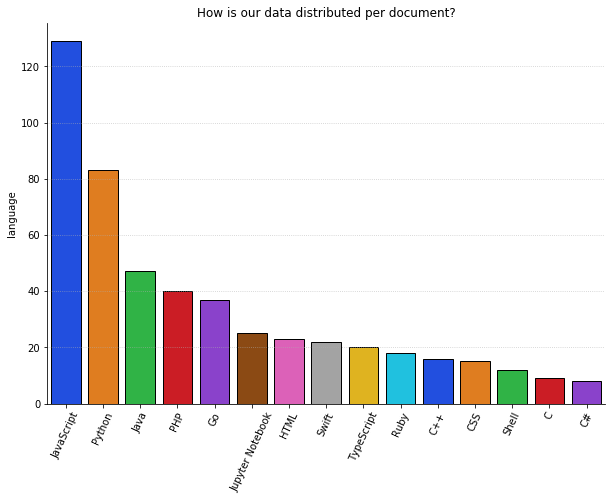

In [13]:
plt.figure(figsize=(10,7))
bar = sns.barplot(x=value_counts.index, y="language", data=value_counts)
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)

plt.title("How is our data distributed per document?")
plt.show()

<div class="alert alert-block alert-info">
<b>Question 1:</b> Does the length of the README vary by programming language?
</div>

Look at Lengths of README files by Language.

In [14]:
df_len = dfx.assign(length = dfx.cleaned.apply(len))
df_len.head()

,language,cleaned,length
0,Python,bert new may whole word masking model release ...,28440
10,Python,align center cdn rawgit jarun googler master g...,14023
100,Ruby,imgur felxx xcpretty fast flexible formatter x...,2395
101,Go,command line tool installing using jenkins jen...,6025
102,JavaScript,align center table colgroup col width colgroup...,2694


In [15]:
# length of READMEs for JavaScript subset
# df_len[df_len['language'] == 'JavaScript']['length'].sort_values(ascending=False)

In [16]:
# # README length by language

# languages = ['JavaScript', 'Python', 'Java', 'PHP', 'Go', 'Jupyter Notebook', 
#              'HTML', 'Swift', 'TypeScript', 'Ruby', 'C++', 'CSS', 'Shell',
#              'C', 'C#']

# bins = 20
# for lang in languages:
#     plt.hist(df_len[df_len['language'] == lang]['length'], bins=bins, alpha=0.8, label=lang)
    
# plt.legend()
# plt.show()

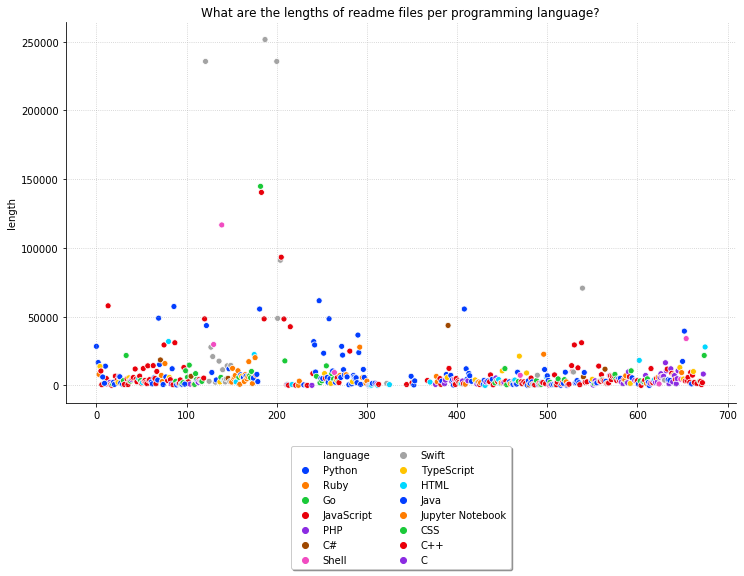

In [17]:
plt.figure(figsize=(12,7))
ax = plt.subplot(111)

plt.title("What are the lengths of readme files per programming language?")
sns.scatterplot(y=df_len.length, x=df_len.index,hue=df_len.language)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
plt.show()

It seems that most of the readme files have under 15,000 actual and meta characters.

We can see a handful of documentations on **Swift** (gray) language topping the character count.

Let's look at the median length per language.

In [18]:
df_len_median_lengths = df_len.groupby("language").median()

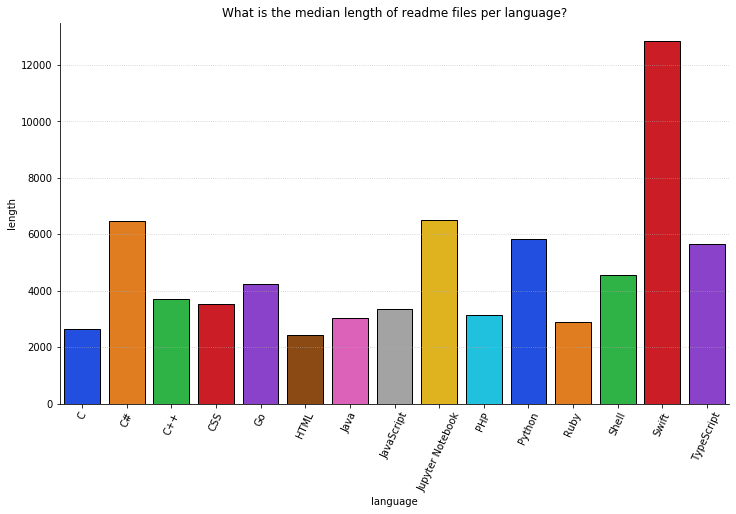

In [19]:
plt.figure(figsize=(12,7))
plt.title("What is the median length of readme files per language?")
bar = sns.barplot(y=df_len_median_lengths.length,x=df_len_median_lengths.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

In the scatter plot above, it seems that there are readme files that are longer than 15,000 characters, let's look at these long readmes.

In [20]:
df_len_top_lengths = df_len[df_len.length > 15000].groupby("language").median()
df_len_top_lengths = df_len_top_lengths.sort_values(by="length",ascending=False)

In [21]:
df_len_top_lengths

,length
language,
Go,144822.0
Swift,70767.0
Java,57419.0
JavaScript,48400.0
Shell,34084.0
C#,31098.5
Python,30668.0
C++,30257.5
HTML,25241.5


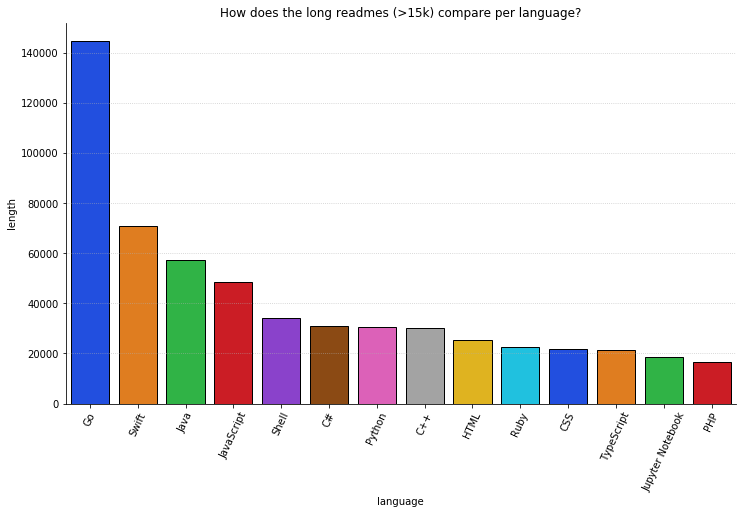

In [22]:
plt.figure(figsize=(12,7))
plt.title("How does the long readmes (>15k) compare per language?")
bar = sns.barplot(y=df_len_top_lengths.length,x=df_len_top_lengths.index)

bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

<div class="alert alert-block alert-info">
<b>Question 2:</b> What are the most common words in READMEs?
</div>

In [23]:
languages = ['JavaScript', 'Python', 'Java', 'PHP', 'Go', 'Jupyter Notebook', 
             'HTML', 'Swift', 'TypeScript', 'Ruby', 'C++', 'CSS', 'Shell',
             'C', 'C#']

In [24]:
value_counts_by_language = []

for lang in languages:
    value_counts = pd.Series(' '.join(df[df.language==lang]['cleaned']).split()).value_counts()
    value_counts_by_language.append(value_counts)

In [25]:
# raw counts by language

# raw_count_js = pd.Series(' '.join(df[df.language=='JavaScript']['cleaned']).split()).value_counts()
# raw_count_p = pd.Series(' '.join(df[df.language=='Python']['cleaned']).split()).value_counts()
# raw_count_j = pd.Series(' '.join(df[df.language=='Java']['cleaned']).split()).value_counts()
# raw_count_php = pd.Series(' '.join(df[df.language=='PHP']['cleaned']).split()).value_counts()
# raw_count_go = pd.Series(' '.join(df[df.language=='Go']['cleaned']).split()).value_counts()
# raw_count_jup = pd.Series(' '.join(df[df.language=='Jupyter Notebook']['cleaned']).split()).value_counts()
# raw_count_html = pd.Series(' '.join(df[df.language=='HTML']['cleaned']).split()).value_counts()
# raw_count_swift = pd.Series(' '.join(df[df.language=='Swift']['cleaned']).split()).value_counts()
# raw_count_ts = pd.Series(' '.join(df[df.language=='TypeScript']['cleaned']).split()).value_counts()
# raw_count_rub = pd.Series(' '.join(df[df.language=='Ruby']['cleaned']).split()).value_counts()
# raw_count_cp = pd.Series(' '.join(df[df.language=='C++']['cleaned']).split()).value_counts()
# raw_count_css = pd.Series(' '.join(df[df.language=='CSS']['cleaned']).split()).value_counts()
# raw_count_shell = pd.Series(' '.join(df[df.language=='Shell']['cleaned']).split()).value_counts()
# raw_count_c = pd.Series(' '.join(df[df.language=='C']['cleaned']).split()).value_counts()
# raw_count_csharp = pd.Series(' '.join(df[df.language=='C#']['cleaned']).split()).value_counts()

#### Plot the Word Frequency by Language

<Figure size 1728x1584 with 0 Axes>

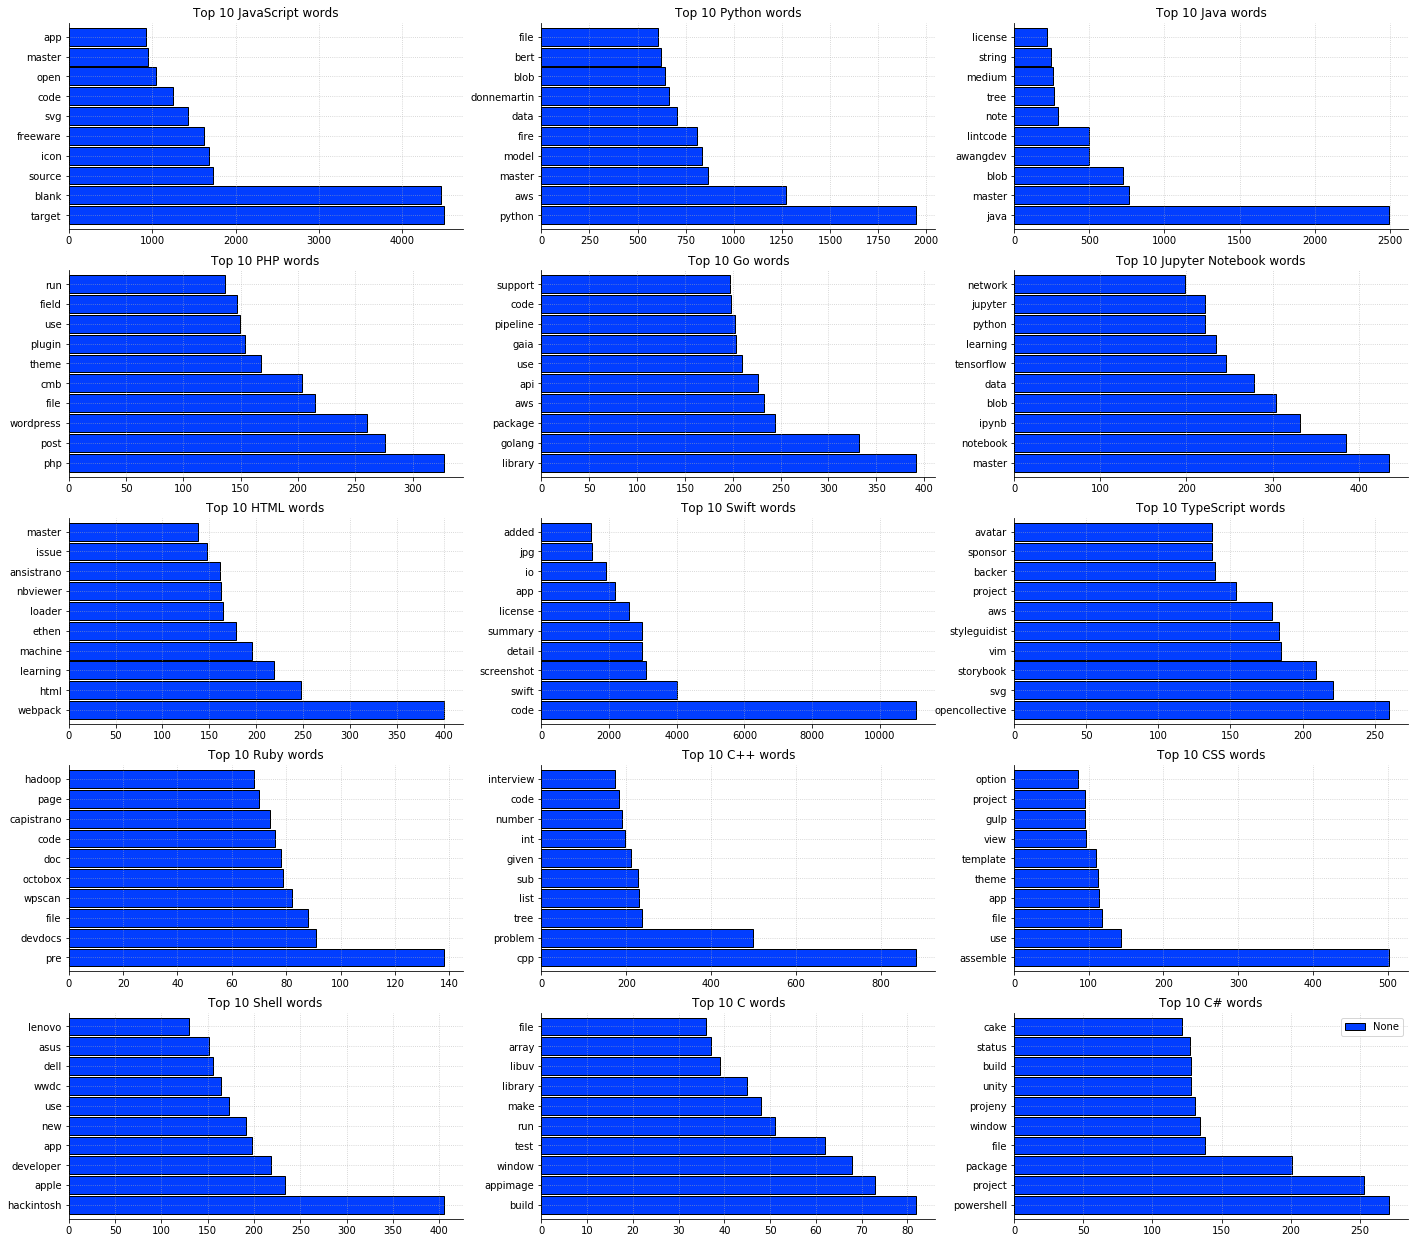

In [29]:
plt.figure(figsize=(24,22))

plt.figure(figsize=(24, 22))
for i, lang in enumerate(value_counts_by_language):
    plt.subplot(5, 3, i+1)
    lang.sort_values(ascending=False)[0:10].plot.barh(width=.9)
    plt.title(f'Top 10 {languages[i]} words')


plt.legend()
plt.show()

Let's look at the frequency of each word by language and as an aggregate. 

In [38]:
word_freq = prepare.word_freq(dfx)
word_freq.sort_values(by="all",ascending=False)

,all,javascript,python,java,php,go,jupyter_notebook,html,swift,typescript,ruby,C+,CSS,C,C#
code,14063,1251,522,94,68,198,151,81,11080,135,76,183,68,14,34
target,5016,4496,113,26,18,65,25,5,38,128,25,26,9,3,15
blank,4794,4467,56,11,17,46,14,1,17,127,18,2,3,1,13
master,4778,954,868,761,87,107,435,138,979,76,24,145,29,12,47
swift,4157,20,9,41,0,4,1,1,4015,1,1,0,0,0,0
app,4032,928,241,50,61,38,0,50,2172,91,45,21,114,6,17
license,3898,319,249,218,93,86,39,47,2600,49,52,27,33,22,31
source,3433,1733,209,60,37,102,24,20,1031,25,25,27,40,14,40
detail,3426,84,89,19,33,23,23,15,2986,15,11,34,37,6,27
screenshot,3260,73,1,13,19,15,0,3,3105,1,3,3,12,0,4


#### Term Frequency Overall

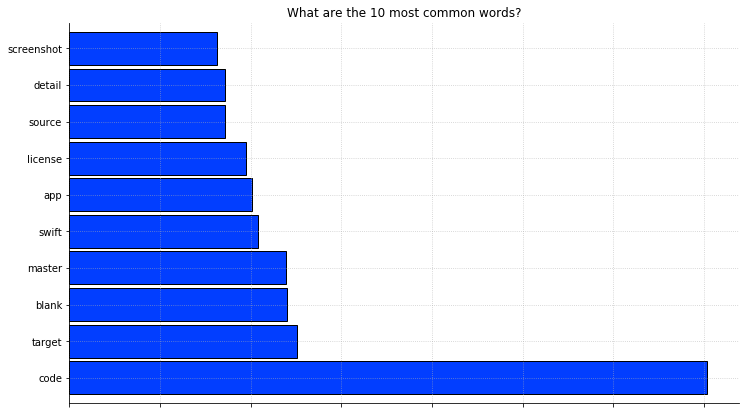

In [57]:
plt.figure(figsize=(12,7))
bar = word_freq["all"].sort_values(ascending=False)[0:10].plot.barh(width=.9)

plt.title("What are the 10 most common words?")
bar.set_xticklabels(bar.get_xticklabels(),rotation=65)
plt.show()

<div class="alert alert-block alert-info">
<b>TAKEAWAYS:</b>

- When we isolate the top ten words with the highest frequency by language, we can see that they are quite distinct. This means that a lot of the 'words' or characters strung together through the scraping are only noise in our data.  

- This is a good guide to improving the quality of our data before creating a best model.  

- We will do more with word frequency in Feature Engineering.
</div>

#### Explore Words Unique to Languages


##### Python Keywords


In [50]:
set(word_freq.columns) - {"python"}

{'C',
 'C#',
 'C+',
 'CSS',
 'all',
 'go',
 'html',
 'java',
 'javascript',
 'jupyter_notebook',
 'php',
 'ruby',
 'swift',
 'typescript'}

In [ ]:
# exclusion = (set(word_freq.columns) - {"python"}) ==0)
# word_freq[word_freq.python >0 and (set(word_freq.columns) - {"python"}) ==0]

In [56]:
word_freq[word_freq.javascript == 0].sort_values(by='python', ascending=False)

,all,javascript,python,java,php,go,jupyter_notebook,html,swift,typescript,ruby,C+,CSS,C,C#
donnemartin,716,0,665,0,0,0,49,0,0,0,0,0,0,0,0
ipynb,863,0,438,0,0,10,332,82,0,0,0,0,1,0,0
nbviewer,742,0,436,0,0,6,137,162,1,0,0,0,0,0,0
mnist,275,0,254,0,0,0,21,0,0,0,0,0,0,0,0
epoch,242,0,240,0,0,0,1,0,0,0,1,0,0,0,0
train,216,0,193,0,0,0,18,2,0,1,0,0,0,0,0
awslabs,191,0,189,0,0,0,0,0,0,2,0,0,0,0,0
pypi,197,0,184,0,0,1,6,0,1,1,0,0,4,0,0
squad,176,0,176,0,0,0,0,0,0,0,0,0,0,0,0
panda,245,0,160,0,0,1,72,8,2,0,0,0,2,0,0


##### Javascript Keywords


### Create Corpus

Make a variable named `corpus`, which is a pd.Series of all the words in `dfx`. Correspondingly, make a variable named `bag` (i.e., "bag of words") which provides us with a list of all words in one big collection.

In [36]:
corpus = pd.Series(" ".join(dfx.cleaned).split())
bag = " ".join(dfx.cleaned)

(-0.5, 399.5, 199.5, -0.5)

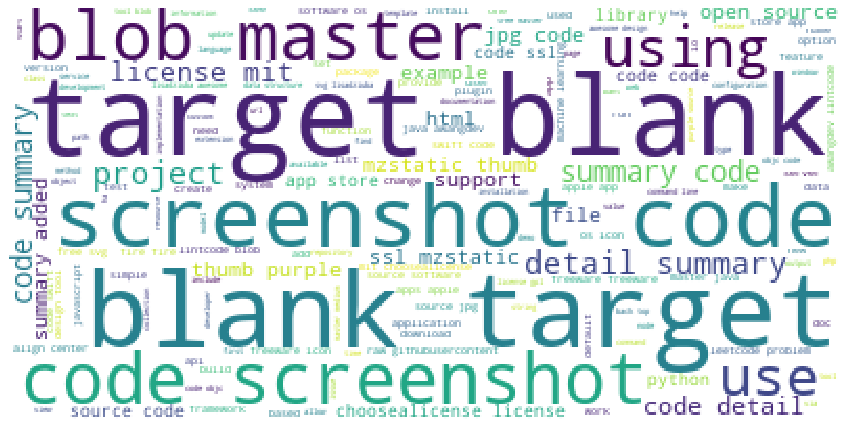

In [37]:
plt.figure(figsize=(15, 8))
img = WordCloud(background_color='white',random_state=1).generate(bag)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

## IV. Model

### TFIDF

Get features using TFIDF

In [52]:
df_dict = dict(df.cleaned)

In [53]:
tfidf = TfidfVectorizer()
sparse = tfidf.fit_transform(df_dict.values())

In [54]:
sparse_matrix = pd.DataFrame(sparse.todense(),columns=tfidf.get_feature_names())

In [55]:
sparse_matrix.head()

,aaa,aaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaj,aaafj,aaai,aab,aabac,...,zybuluo,zydeco,zydis,zypper,zysuper,zyszys,zythum,zythumbnailtableview,zzan,zzmark
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.006662,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### B. Split Train-Test

In [56]:
X = tfidf.fit_transform(df.cleaned)
y = df.language

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

### Decision Tree

In [58]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dt = DecisionTreeClassifier(criterion='entropy', splitter='best',
                           max_depth=5, min_samples_split=3,
                           min_samples_leaf=4,
                           random_state=123).fit(X_train, y_train)

train['predicted'] = dt.predict(X_train)
test['predicted'] = dt.predict(X_test)

In [59]:
print('Decision Tree Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Decision Tree Train Accuracy: 59.80%
---
Confusion Matrix
actual            C  C#  C++  CSS  Go  HTML  Java  JavaScript  \
predicted                                                       
C++               0   0    4    0   0     0     0           0   
CSS               0   0    0    6   0     0     0           0   
Go                0   0    0    0   8     0     0           0   
HTML              0   0    0    0   0     4     2           0   
Java              1   0    0    0   0     0    27           1   
JavaScript        6   6    9    5  21    10     9          95   
Jupyter Notebook  0   0    0    0   0     1     0           0   
PHP               0   0    0    0   0     1     0           4   
Python            0   0    0    0   1     1     0           3   
Shell             0   0    0    1   0     1     0           0   
Swift             0   0    0    0   0     0     0           0   

actual            Jupyter Notebook  PHP  Python  Ruby  Shell  Swift  \
predicted                

In [60]:
print('Decision Tree Test Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Decision Tree Test Accuracy: 47.52%
---
Confusion Matrix
actual            C  C#  C++  CSS  Go  HTML  Java  JavaScript  \
predicted                                                       
CSS               0   0    0    0   0     0     0           1   
Go                0   0    0    0   1     0     0           0   
HTML              0   0    0    1   0     0     0           0   
Java              0   0    0    0   2     1     8           0   
JavaScript        1   1    3    2   4     3     1          25   
Jupyter Notebook  0   0    0    0   0     0     0           0   
PHP               1   0    0    0   0     1     0           0   
Python            0   0    0    0   0     0     0           0   
Shell             0   1    0    0   0     0     0           0   
Swift             0   0    0    0   0     0     0           0   

actual            Jupyter Notebook  PHP  Python  Ruby  Shell  Swift  \
predicted                                                             
CSS                 

#### Takeaways

- The Decision Tree is dealing with such an imbalanced dataset with javascript having 129 observations and C# coming in with the fewest samples, 8.

- By adjusting the hyperparameters of the DT Model, I was able to move the test accuracy closer to the train accuracy, but I think we can do better predictions with better data.

- We will work on cutting out noise in our data and balancing our set in feature engineering.

### Logistic Regression

In [61]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [62]:
# Train Evaluation

print('Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Logistic Regression Train Accuracy: 59.55%
---
Confusion Matrix
actual            C  C#  C++  CSS  Go  HTML  Java  JavaScript  \
predicted                                                       
C++               0   0    4    0   0     0     0           0   
Go                0   0    0    0  10     0     0           0   
Java              0   0    0    0   0     0    28           0   
JavaScript        7   6    9   12  18    16     9         103   
Jupyter Notebook  0   0    0    0   0     0     0           0   
PHP               0   0    0    0   0     0     0           0   
Python            0   0    0    0   2     2     1           0   
Swift             0   0    0    0   0     0     0           0   

actual            Jupyter Notebook  PHP  Python  Ruby  Shell  Swift  \
predicted                                                             
C++                              0    0       0     0      0      0   
Go                               0    0       0     0      0      0   
J

In [63]:
# Test Evaluation

print('Logistic Regression Test Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Logistic Regression Test Accuracy: 31.68%
---
Confusion Matrix
actual            C  C#  C++  CSS  Go  HTML  Java  JavaScript  \
predicted                                                       
Java              0   0    0    0   0     0     1           0   
JavaScript        2   2    3    3   7     5     8          26   
Jupyter Notebook  0   0    0    0   0     0     0           0   
Python            0   0    0    0   0     0     0           0   

actual            Jupyter Notebook  PHP  Python  Ruby  Shell  Swift  \
predicted                                                             
Java                             0    0       0     0      0      0   
JavaScript                       3    8      13     4      2      4   
Jupyter Notebook                 1    0       0     0      0      0   
Python                           1    0       4     0      0      0   

actual            TypeScript  
predicted                     
Java                       0  
JavaScript                

### Feature Engineering

In [ ]:
JavaScript	129	0.255952
Python	83	0.164683
Java	47	0.093254
PHP	40	0.079365